In [8]:
import os
import sys
from pathlib import Path
import numpy as np
import tensorflow as tf
tf.__version__

'1.12.0'

In [1]:
from absl import flags, app
flags.DEFINE_string('data_dir', 'hw2_data',
                    'Directory containing sub-directories tf_segmentation and '
                    'images.')
FLAGS = flags.FLAGS

FLAGS(['notebook']) # for jupyter without main

['notebook']

In [6]:

def get_filename_data_readers(image_ids_file, get_labels=False,
                              x_jpg_dir=None, y_png_dir=None):
    """Given image IDs file, returns Datasets, which generate image paths.
  
    The goal of this function is to convert from image IDs to image paths.
    Specifically, the return type should be:
      if get_labels == False, return type should be tf.data.Dataset.
      Otherwise, return type should be pair (tf.data.Dataset, tf.data.Dataset).
    In both cases, the Dataset objects should be "not batched".
  
    For example, if the file contains 2 lines: "0000\n0001", then the returned
    dataset should give an iterator that when its tensor is ran, gives "0000" the
    first time and gives "0001" the second time.
  
    Args:
      image_ids_file: text with one image ID per line.
      get_labels: If set, returns 2 Datasets: the containing the image files (x)
        and the second containing the segmentation labels (y). If not, returns
        only the first argument.
      x_jpg_dir: Directory where each image lives. Specifically, image with
        ID "image1" will live on "x_jpg_dir/image1.jpg".
      y_png_dir: Directory where each segmentation mask lives. Specifically,
        image with ID "image1" will live on "x_png_dir/image1.png".
  
    Returns:
      instance of tf.data.Dataset, or pair of instances (if get_labels == True).
    """
    x_jpg_dir = x_jpg_dir or os.path.join(FLAGS.data_dir, 'images')
    y_png_dir = y_png_dir or os.path.join(FLAGS.data_dir, 'tf_segmentation')
    
    # TODO(student): Write code.
    if isinstance(image_ids_file, str):
        with open(image_ids_file) as rdr:
            image_ids = [l.strip() for l in rdr]
    else:
        image_ids = [l.strip() for l in image_ids_file]

    def x_jpg_paths():
        yield from (os.path.join(x_jpg_dir, f'{ii}.jpg') for ii in image_ids)

    def y_png_paths():
        yield from (os.path.join(y_png_dir, f'{ii}.png') for ii in image_ids)

    x_dataset = tf.data.Dataset.from_generator(generator=x_jpg_paths, output_types=tf.string,
                                               output_shapes=tf.TensorShape([]))
    
    if get_labels:
        y_dataset = tf.data.Dataset.from_generator(generator=y_png_paths, output_types=tf.string,
                                                output_shapes=tf.TensorShape([]))
        return x_dataset, y_dataset
    else:
        return x_dataset


image_ids_file = [p.name.replace('.jpg', '') for p in Path('hw2_data/images').glob('*.jpg')]
x_data, y_data = get_filename_data_readers(image_ids_file=image_ids_file, get_labels=True)

In [99]:
def decode_image_with_padding(im_file, decode_fn=tf.image.decode_jpeg,
                              channels=3, pad_upto=500):
    """Reads an image, decodes, and pads its spatial dimensions, all in TensorFlow
  
    Args:
      im_file: tf.string tensor, containing path to image file.
      decode_fn: Tensorflow function for converting
      channels: Image channels to decode. For data (x), set to 3 channels (i.e. RGB).
        For labels (segmentation masks), set to 1, because other 2 channels contain
        identical information.
      pad_upto: Number of pixels to pad to.
  
    Returns:
      Pair of Tensors:
        The first must be tf.int vector with 2 entries: containing the original height
          and width of the image.
        The second must be a tf.int matrix with size (pad_upto, pad_upto, 3)
          i.e. the contents of the image, with zero-padding.
    """
    # TODO(student): Write code.
    image = tf.image.decode_jpeg(tf.io.read_file(im_file), channels=3)
    image = tf.to_int32(image)

    #padded = tf.fill([pad_upto, pad_upto, channels], 0)
    #tf.slice(padded, [0, 0, 0], tf.shape(image)).assign(image)

    #padded[:tf.shape(image)[0], :tf.shape(image)[1], :].assign(image)
    #padded[:image.shape[0], :image.shape[1], :].assign(image)
    height, width = tf.shape(image)[0], tf.shape(image)[1]

    right_pad = tf.zeros([height, pad_upto - width, channels], dtype=tf.int32)
    half_padded = tf.concat([image, right_pad], axis=1)
    bottom_pad = tf.zeros([pad_upto - height, pad_upto, channels], dtype=tf.int32)
    padded = tf.concat([half_padded, bottom_pad], axis=0)
    return tf.shape(image), padded,

In [111]:
shapes = tf.placeholder(tf.int32, [None, 2])

In [125]:
def make_loss_mask(shapes, maxlen=500):
    """Given tf.int Tensor matrix with shape [N, 2], make N 2D binary masks.
  
    These binary masks will be used "to mask the loss". Specifically, if the
    image is shaped as (300 x 400) and therefore so its labels, we only want
    to penalize the model for misclassifying within the image boundary (300 x 400)
    and ignore values outside (e.g. at pixel [350, 380]).
  
    Args:
      shapes: tf.int Tensor with shape [N, 2]. Entry shapes[i] will be a vector:
        [image height, image width].
  
    Returns:
      tf.float32 mask of shape [N, 500, 500], with mask[i, h, w] set to 1.0
      iff shapes[i, 0] < h and shapes[i, 1] < w.
    """
    # TODO(student): Write code.
    rows = tf.sequence_mask(shapes[:, 0], maxlen=maxlen)
    cols = tf.sequence_mask(shapes[:, 1], maxlen=maxlen)
    rows = tf.expand_dims(rows, -1) # N x L x 1
    cols = tf.expand_dims(cols, 1) # N x 1 x L
    mask = tf.matmul(tf.to_float(rows), tf.to_float(cols))
    return mask

sess.run(make_loss_mask(shapes), feed_dict={shapes: [[2,3],[3,3],[2,4]]})

array([[[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [126]:
sess = tf.Session()
iter = x_data.make_initializable_iterator() 
next = iter.get_next()    
sess.run(iter.initializer)
sess.run(next)

b'hw2_data/images/0071.jpg'

----
# Segmentation Model



In [15]:
%config Application.log_level="INFO"
import random
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union, List

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import VisionDataset
import logging as log
import functools
from PIL import Image

log.basicConfig(level=log.INFO)
log.info(f'Torch: {torch.__version__}  torchvision:{torchvision.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log.info(f'using device {device}')

I0930 22:47:51.276298 47764608122560 <ipython-input-15-e50bad22b86d>:18] Torch: 1.1.0  torchvision:0.3.0
I0930 22:47:51.279188 47764608122560 <ipython-input-15-e50bad22b86d>:20] using device cuda


In [16]:

class HW2Dataset(VisionDataset):

    def __init__(self, image_ids_file: Union[str, List[str]], get_labels=False, 
                 x_jpg_dir: str=None, y_png_dir: str=None, data_dir: str=None, pad_upto=500, device=device):
        assert x_jpg_dir or data_dir # either one must be found
        super().__init__(x_jpg_dir or data_dir)
        
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean, std
        self.pad_upto = pad_upto
        img_dir = Path(x_jpg_dir) if x_jpg_dir else Path(data_dir) / 'images'
        lbl_dir = Path(y_png_dir) if y_png_dir else Path(data_dir) / 'tf_segmentation'

        if isinstance(image_ids_file, str):
            with open(image_ids_file) as rdr:
                image_ids = [l.strip() for l in rdr]
        else:
            image_ids = [l.strip() for l in image_ids_file]

        self.img_paths = [img_dir / f'{ii}.jpg' for ii in image_ids]
        self.lbl_paths = None
        if get_labels:
            self.lbl_paths = [lbl_dir / f'{ii}.png' for ii in image_ids]
        log.info(f'Found {len(self)} images; get_labels ={get_labels}')
        self.device = device
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img = self.get_image(self.img_paths[index])
        lbl = self.get_label(self.lbl_paths[index]) if self.lbl_paths else None
        return img, lbl

    def get_image(self, path):
        img = Image.open(path).convert('RGB')
        img = self.to_tensor(img).to(self.device)                # [Ch=3 x W x H]
        pad_img = torch.zeros(3, self.pad_upto, self.pad_upto, device=device)
        pad_img[:, :img.shape[1], :img.shape[2]] = img
        return self.normalize(pad_img)

    def get_label(self, path):
        label = Image.open(path).convert('I')
        label = self.to_tensor(label).to(self.device)  # [Ch=1 x W x H]
        label = label.squeeze(0)                  # [W x H]
        h, w = label.shape
        label.masked_fill_(label == 255, 0)       # fill zeros where border=255
        pad_label = torch.zeros(self.pad_upto, self.pad_upto, dtype=torch.long, device=self.device)
        pad_label[:h, :w] = label
        rows = torch.arange(self.pad_upto, device=self.device) < h
        cols = torch.arange(self.pad_upto, device=self.device) < w
        # Note: pytorch+cuda only supports float multiplication. 
        mask = torch.matmul(rows.unsqueeze(1).float(), cols.unsqueeze(0).float())  #[h x 1] [1 x w] =  [h x w]
        return (pad_label, mask)

In [17]:
image_ids = [i.name.replace('.jpg', '') for i in Path('hw2_data/images').glob('*.jpg')]
# TODO: divide into dev and test

In [18]:
dataset = HW2Dataset(image_ids, data_dir='hw2_data', get_labels=True)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                          shuffle=True, num_workers=0)

I0930 22:48:02.431622 47764608122560 <ipython-input-16-e68381e0721f>:24] Found 2330 images; get_labels =True


In [19]:
for x, (y, m) in trainloader:
    print(m)
    break

tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 

In [25]:
from tqdm import tqdm_notebook as tqdm

class VisionModel(nn.Module):
    
    def __init__(self, n_classes, size=500):
        super().__init__()
        self.n_classes = n_classes
        self.height = self.width = size
        #self.maxpool = nn.MaxPool2d(3, 3, padding=1)
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)  #[N x 3 x 500 x 500] -->  [N x 6 x 500 x 500]    
        self.conv2 = nn.Conv2d(6, n_classes, 5, padding=2) # [N x 6 x 500 x 500]  --> [N x n_classes x 500 x 500] 

    def forward(self, batch, probs=None):
        # batch: [B x Ch=3 x W=500 x H=500]
        x = batch
        x = F.relu(self.conv1(x))
        #print(1.5, x.shape)        
        #x = self.maxpool(x)
        x = F.relu(self.conv2(x)) # [N x classes=21 x H x W]
        #print(2.5, x.shape)
        #x = self.maxpool(x) 
        if not probs:
            return x
        else:
            assert probs in {'raw', 'log'}
            return (F.log_softmax if probs == 'log' else F.softmax)(x, dim=1)

class Trainer:

    def __init__(self, model, train_data, dev_data, device=device):
        self.model = model.to(device)
        self.optim = torch.optim.Adam(params=model.parameters())
        self.train_data = train_data
        self.dev_data = dev_data
        self.loss_func = nn.CrossEntropyLoss(reduction='none')

    def train(self, steps, checkpt=10):
        step = 0
        loss = None
        with tqdm(self.train_data, total=steps) as data_bar:
            for images, (labels, mask) in data_bar:
                if step % checkpt == 0:
                    log.info(f"Checkpoint at step = {step}; last loss={loss}")
                    # TODO: log validation loss
                self.optim.zero_grad()
                predictions = self.model(images)
                k = self.model.n_classes
                assert predictions.shape[1] == k
                b, _, h, w = predictions.shape
                # preds = [B x k x H x W] -> [B x W x H x k] -> [ B*W*H, k]
                ps = predictions.transpose(1, 3).contiguous().view(b, -1, k).view(-1, self.model.n_classes)
                # labels = [B x H x W] -> [ B*W*H, 1]
                ls = labels.view(-1)
                losses = self.loss_func(ps, ls)
                # TODO: mask oout padding
                loss = losses.mean()
                loss.backward()
                step += 1
                #data_bar.set_postfix(loss=loss.item())


model = SegmentationModel()
model.train(image_ids)

I0930 22:50:38.367038 47764608122560 <ipython-input-24-85037f212b81>:63] Found 2330 images; Train:2097 Validation:233
I0930 22:50:38.394676 47764608122560 <ipython-input-16-e68381e0721f>:24] Found 2097 images; get_labels =True
I0930 22:50:38.418638 47764608122560 <ipython-input-16-e68381e0721f>:24] Found 2097 images; get_labels =True


I0930 22:50:39.709510 47764608122560 <ipython-input-25-5cc00aabc3f6>:43] Checkpoint at step = 0; last loss=None


RuntimeError: CUDA out of memory. Tried to allocate 1.96 GiB (GPU 0; 10.92 GiB total capacity; 9.73 GiB already allocated; 599.50 MiB free; 59.54 MiB cached)

In [27]:
torch.cuda.empty_cache()

In [24]:
class SegmentationModel:
    """Class that can segment images into 21 classes (class 0 being background).
  
    You must implement the following in this class:
    + load()
    + predict()
    which will be called by the auto-grader
  
    + train()
    + save()
    which will NOT be called by the auto-grader, but you must implement them for
    repeatability. After the grading period, we will re-train all models to make
    sure their present training will get their results.
    """

    def __init__(self, num_classes=21):
        # 0: background class, {1, .., 20} are for class labels.
        self.num_classes = num_classes
        self.batch_size = 100  # You can change or remove
        self.model = VisionModel(n_classes=num_classes)

    def load(self, model_in_file):
        """Restores parameters of model from `model_in_file`."""
        pass

    def predict(self, images):
        """Predicts segments of some images.
    
        This method WILL BE CALLED by auto-grader. Please do not change signature of
        function [though adding optional arguments is fine].
    
        Args:
          images: List of images. All will be padded to 500x500 by autograder. The
            list can be a primitive list or a numpy array. To go from the former to
            the latter, just wrap as np.array(images).
    
        Returns:
          List of predictions (or numpy array). If np array, must be of shape:
          N x 500 x 500 x 21, where N == len(images). Our evaluation script will
          take the argmax on the last column for accuracy (and might calculate AUC).
        """
        pass

    def train(self, train_ids_file):
        """Trains the model.
    
        This method WILL BE CALLED by our scripts, after submission period. Please
        do not add required arguments. Feel free to completely erase its body.
    
        Args:
          train_ids_file: file containing image IDs.
        """
        data_dir = FLAGS.data_dir
        #image_ids = [i.name.replace('.jpg', '') for i in Path(data_dir, 'images').glob('*.jpg')]
        if isinstance(train_ids_file, list):
            image_ids = train_ids_file
        else:
            with open(train_ids_file, 'r', 'utf-8') as f:
                image_ids = [l.strip() for l in f]
        random.shuffle(image_ids)
        split = int(0.9 * len(image_ids))
        train_ids, dev_ids = image_ids[:split], image_ids[split:]
        log.info(f'Found {len(image_ids)} images; Train:{len(train_ids)} Validation:{len(dev_ids)}')
        
        train_data = HW2Dataset(train_ids, data_dir=data_dir, get_labels=True)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)
        dev_data = HW2Dataset(train_ids, data_dir=data_dir, get_labels=True)
        dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=self.batch_size,
                                          shuffle=False, num_workers=0)

        # TODO(student): Feel free to remove if you do not use.
        trainer = Trainer(self.model, train_data=train_loader, dev_data=dev_loader)
        trainer.train(steps=1000, checkpt=100)

    def save(self, model_out_file):
        """Saves model parameters to disk."""
        pass

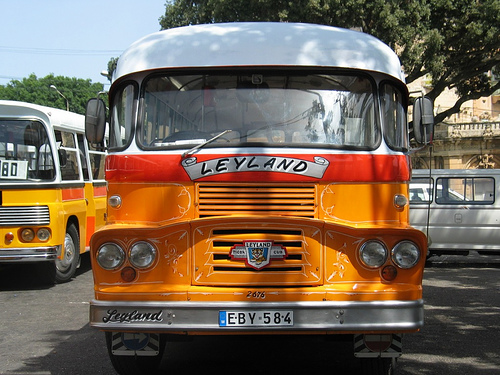

In [50]:
Image.open('hw2_data/images/0000.jpg')

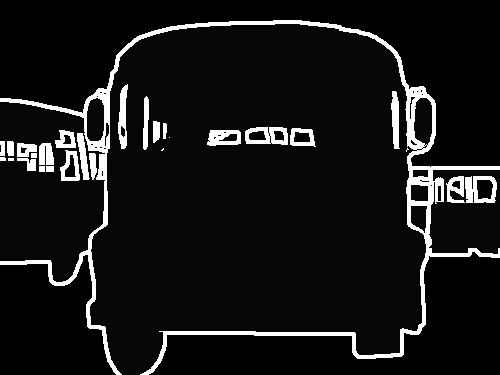

In [51]:
Image.open('hw2_data/tf_segmentation/0000.png')

In [96]:
transforms.ToTensor()(Image.open('hw2_data/tf_segmentation/0002.png').convert('I')).shape

torch.Size([1, 500, 375])

In [17]:
!ls hw2_data/images/0000.jpg

hw2_data/images/0000.jpg


In [310]:
to_tensor = transforms.ToTensor()
c = Counter()
for i in Path('hw2_data/tf_segmentation').glob('*.png'):
    t = to_tensor(Image.open(i).convert('I'))
    c.update(t.view(-1).tolist())

print(len(c))
#transforms.ToTensor()(Image.open('hw2_data/tf_segmentation/0002.png').convert('I')).shape

22


In [306]:
from matplotlib import pyplot as plt
import math

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 22 artists>

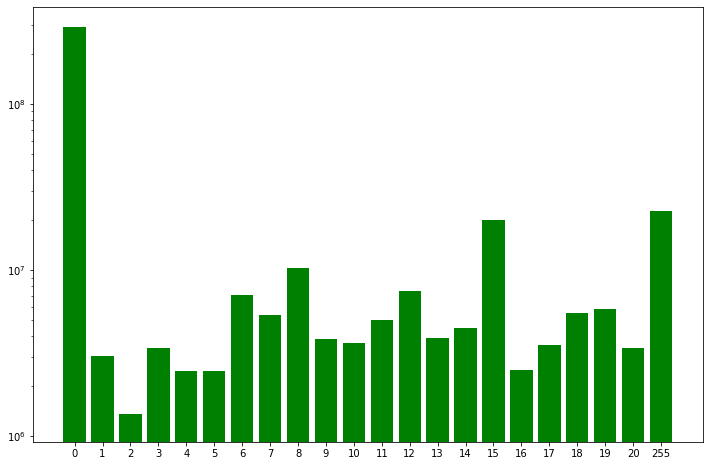

In [309]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_yscale('log')
keys = sorted(c.keys())
values = [c[k] for k in keys]
ax.bar([str(n) for n in keys], values, color='g')

In [26]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Building jupyterlab assets (build:prod:minimize)
/^C
Traceback (most recent call last):
  File "/Users/tg/miniconda3/envs/vocareum/bin/jupyter-labextension", line 10, in <module>
    sys.exit(main())
  File "/Users/tg/miniconda3/envs/vocareum/lib/python3.6/site-packages/jupyter_core/application.py", line 266, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/Users/tg/miniconda3/envs/vocareum/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/tg/miniconda3/envs/vocareum/lib/python3.6/site-packages/jupyterlab/labextensions.py", line 298, in start
    super(LabExtensionApp, self).start()
  File "/Users/tg/miniconda3/envs/vocareum/lib/python3.6/site-packages/jupyter_core/application.py", line 255, in start
    self.subapp.start()
  File "/Users/tg/miniconda3/envs/vocareum/lib/python3.6/site-packages/jupyterlab/labextensions.py", line 105, in start
    core_config=self.co

In [15]:
torch.zeros(10, device=device)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')